### Mooring Report, Lake Zug, 2026.01.14

In [1]:
# imports
import ewgreaders as ewg
import pylake
import os
from glob import glob
import json
import xarray as xr
import numpy as np
import pandas as pd
import scipy
import dolfyn as dlfn
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

c:\Users\herremha\AppData\Local\anaconda3\envs\ewg\Lib\site-packages\pylake\pylake.py:3: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


In [2]:
lake = 'Zugersee'
location = 'LZC'
year = '2026'
date = '20260114'

t_start = '2025-11-01'
t_end = '2026-01-13'

In [3]:
mreader = ewg.mooring_reader.MooringReader(lake, location, year, date)
adcps = mreader.get_adcps()
thermistors = mreader.get_thermistors()
oxygen_loggers = mreader.get_oxygen_loggers()

### ADCPs

In [4]:
adcps

[{'instrument': 'adcp', 'serial_id': '8315', 'mab': 123, 'comments': 'up'},
 {'instrument': 'adcp', 'serial_id': '672', 'mab': 98, 'comments': 'up'},
 {'instrument': 'adcp', 'serial_id': '1728', 'mab': 98, 'comments': 'down'},
 {'instrument': 'adcp', 'serial_id': '16549', 'mab': 41.4, 'comments': 'up'}]

In [5]:
all_adcp = []
for adcp in adcps:
    serial_id = adcp['serial_id']

    areader = ewg.adcp_reader.ADCPReader(serial_id, lake, location, year, date)
    fpath = areader.locate_data_file('L0')
    ds = areader.load_from_L0(fpath)
    ds = areader.range_to_depth(ds)
    ds = areader.run_qa(ds)
    print(areader.depth, ds.attrs['cell_size'])
    ds = ds.sel(time=slice(t_start, t_end))
    all_adcp.append(ds)


Reading file Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2026/Mooring/20260114/LZC/L0\12U8315.000 ...
43.408226013183594 1.0

Reading file Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2026/Mooring/20260114/LZC/L0\3U672.000 ...
71.59141540527344 1.5

Reading file Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2026/Mooring/20260114/LZC/L0\6D1728.000 ...
80.0 1.0

Reading file Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2026/Mooring/20260114/LZC/L0\3U16549.000 ...
131.96441650390625 1.0


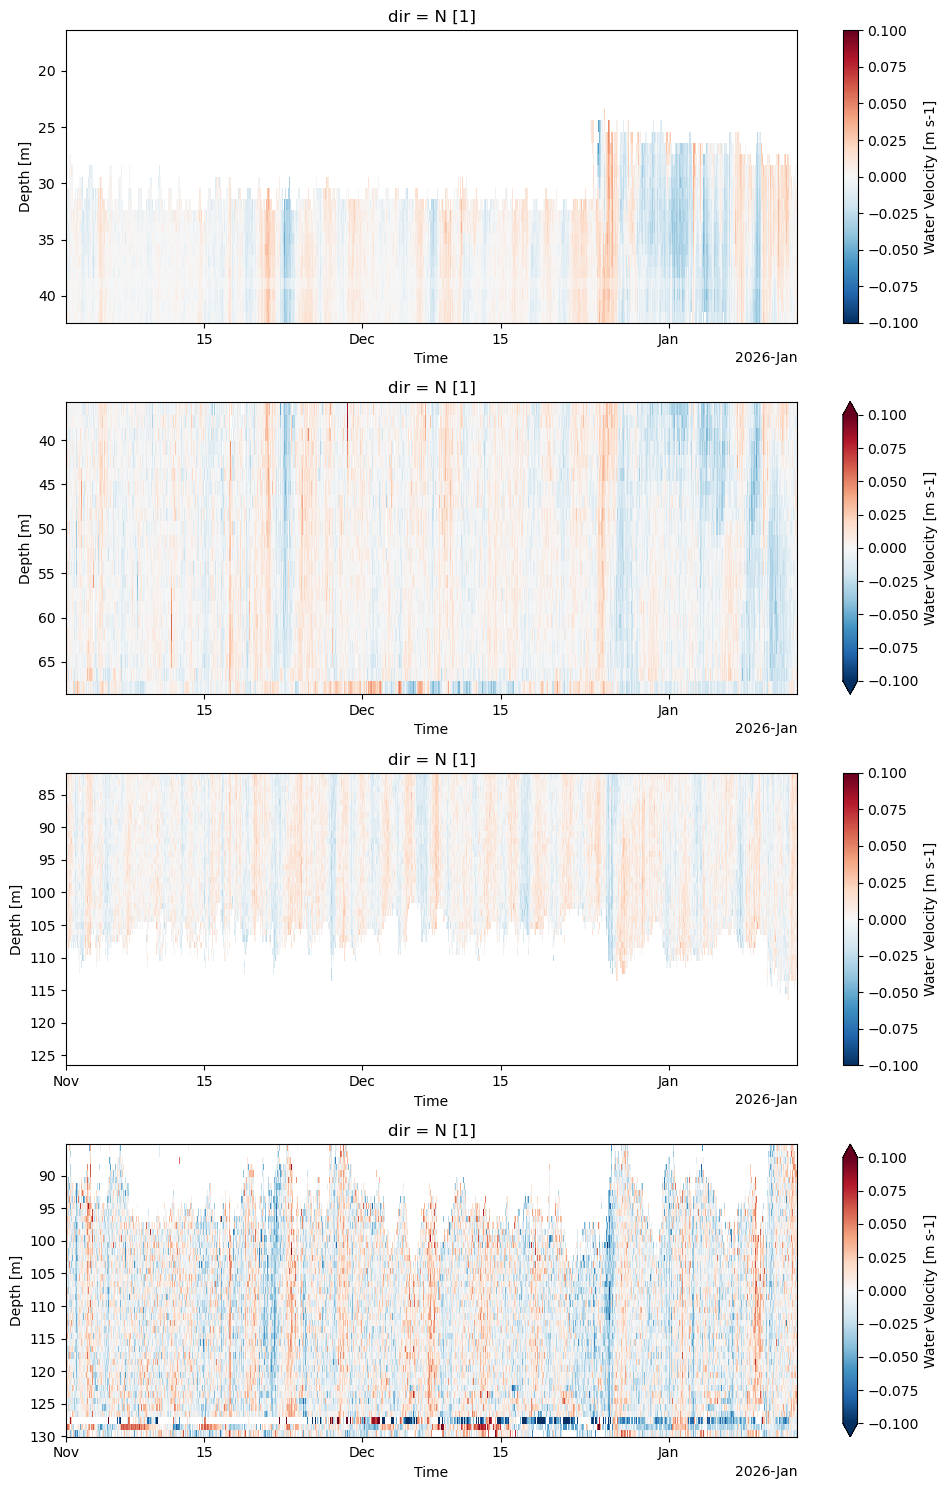

In [6]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10, 15))

for i, d in enumerate(all_adcp):
    d.vel.sel(dir='N').plot(cmap='RdBu_r', vmin=-0.1, vmax=0.1, ax=ax[i])

    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('Depth [m]')

    ax[i].invert_yaxis()

plt.tight_layout()
plt.show()

### Oxygen Loggers

In [7]:
oxygen_loggers

[{'instrument': 'minidot', 'serial_id': '007431', 'mab': 70, 'comments': ''},
 {'instrument': 'minidot', 'serial_id': '893460', 'mab': 65, 'comments': ''},
 {'instrument': 'minidot', 'serial_id': '969903', 'mab': 60, 'comments': ''},
 {'instrument': 'minidot', 'serial_id': '899457', 'mab': 55, 'comments': ''},
 {'instrument': 'minidot', 'serial_id': '990558', 'mab': 50, 'comments': ''},
 {'instrument': 'minidot', 'serial_id': '867666', 'mab': 45, 'comments': ''}]

In [8]:
ds_chain = []
for ol in oxygen_loggers:
    serial_id = ol['serial_id']

    oreader = ewg.o2_reader.O2Reader(serial_id, lake, location, year, date)
    fpath = os.path.join(mreader.dpath_L0, f'7450-{serial_id}/Cat.txt')
    oreader.fpath = fpath
    oreader.sensor = oreader.get_sensor_type()
    oreader.mab = oreader.get_mab()
    oreader.depth = oreader.set_depth()

    ds = oreader.load_from_L0()
    ds = ds.sel(time=slice(t_start, t_end))
    ds['d_oxygen_conc'] *= (1000/32)    # conver to umol/L
    ds_chain.append(ds)

ds_do = mreader.create_instrument_chain(ds_chain)

C:\Users\herremha\elcres\ewgreaders\ewgreaders\readers\mooring_reader.py:243: FutureWarning: In a future version of xarray the default value for coords will change from coords='different' to coords='minimal'. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set coords explicitly.
  return xr.concat(ds_aligned, dim='depth')


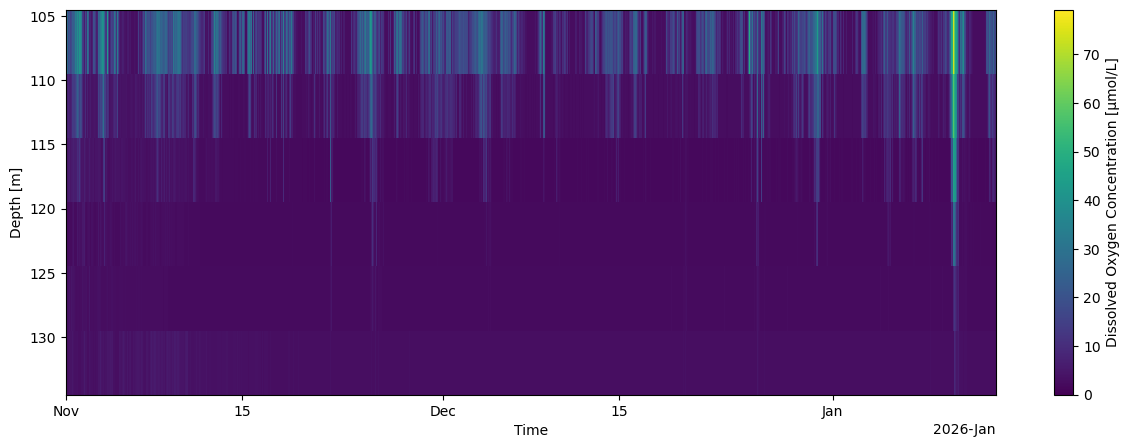

In [9]:
fig, ax = plt.subplots(figsize=(15, 5))
im = ds_do.d_oxygen_conc.plot(cmap='viridis', vmin=0, ax=ax)

ax.set_xlabel("Time")
ax.set_ylabel('Depth [m]')
im.colorbar.set_label("Dissolved Oxygen Concentration [µmol/L]")

ax.invert_yaxis()
plt.show()

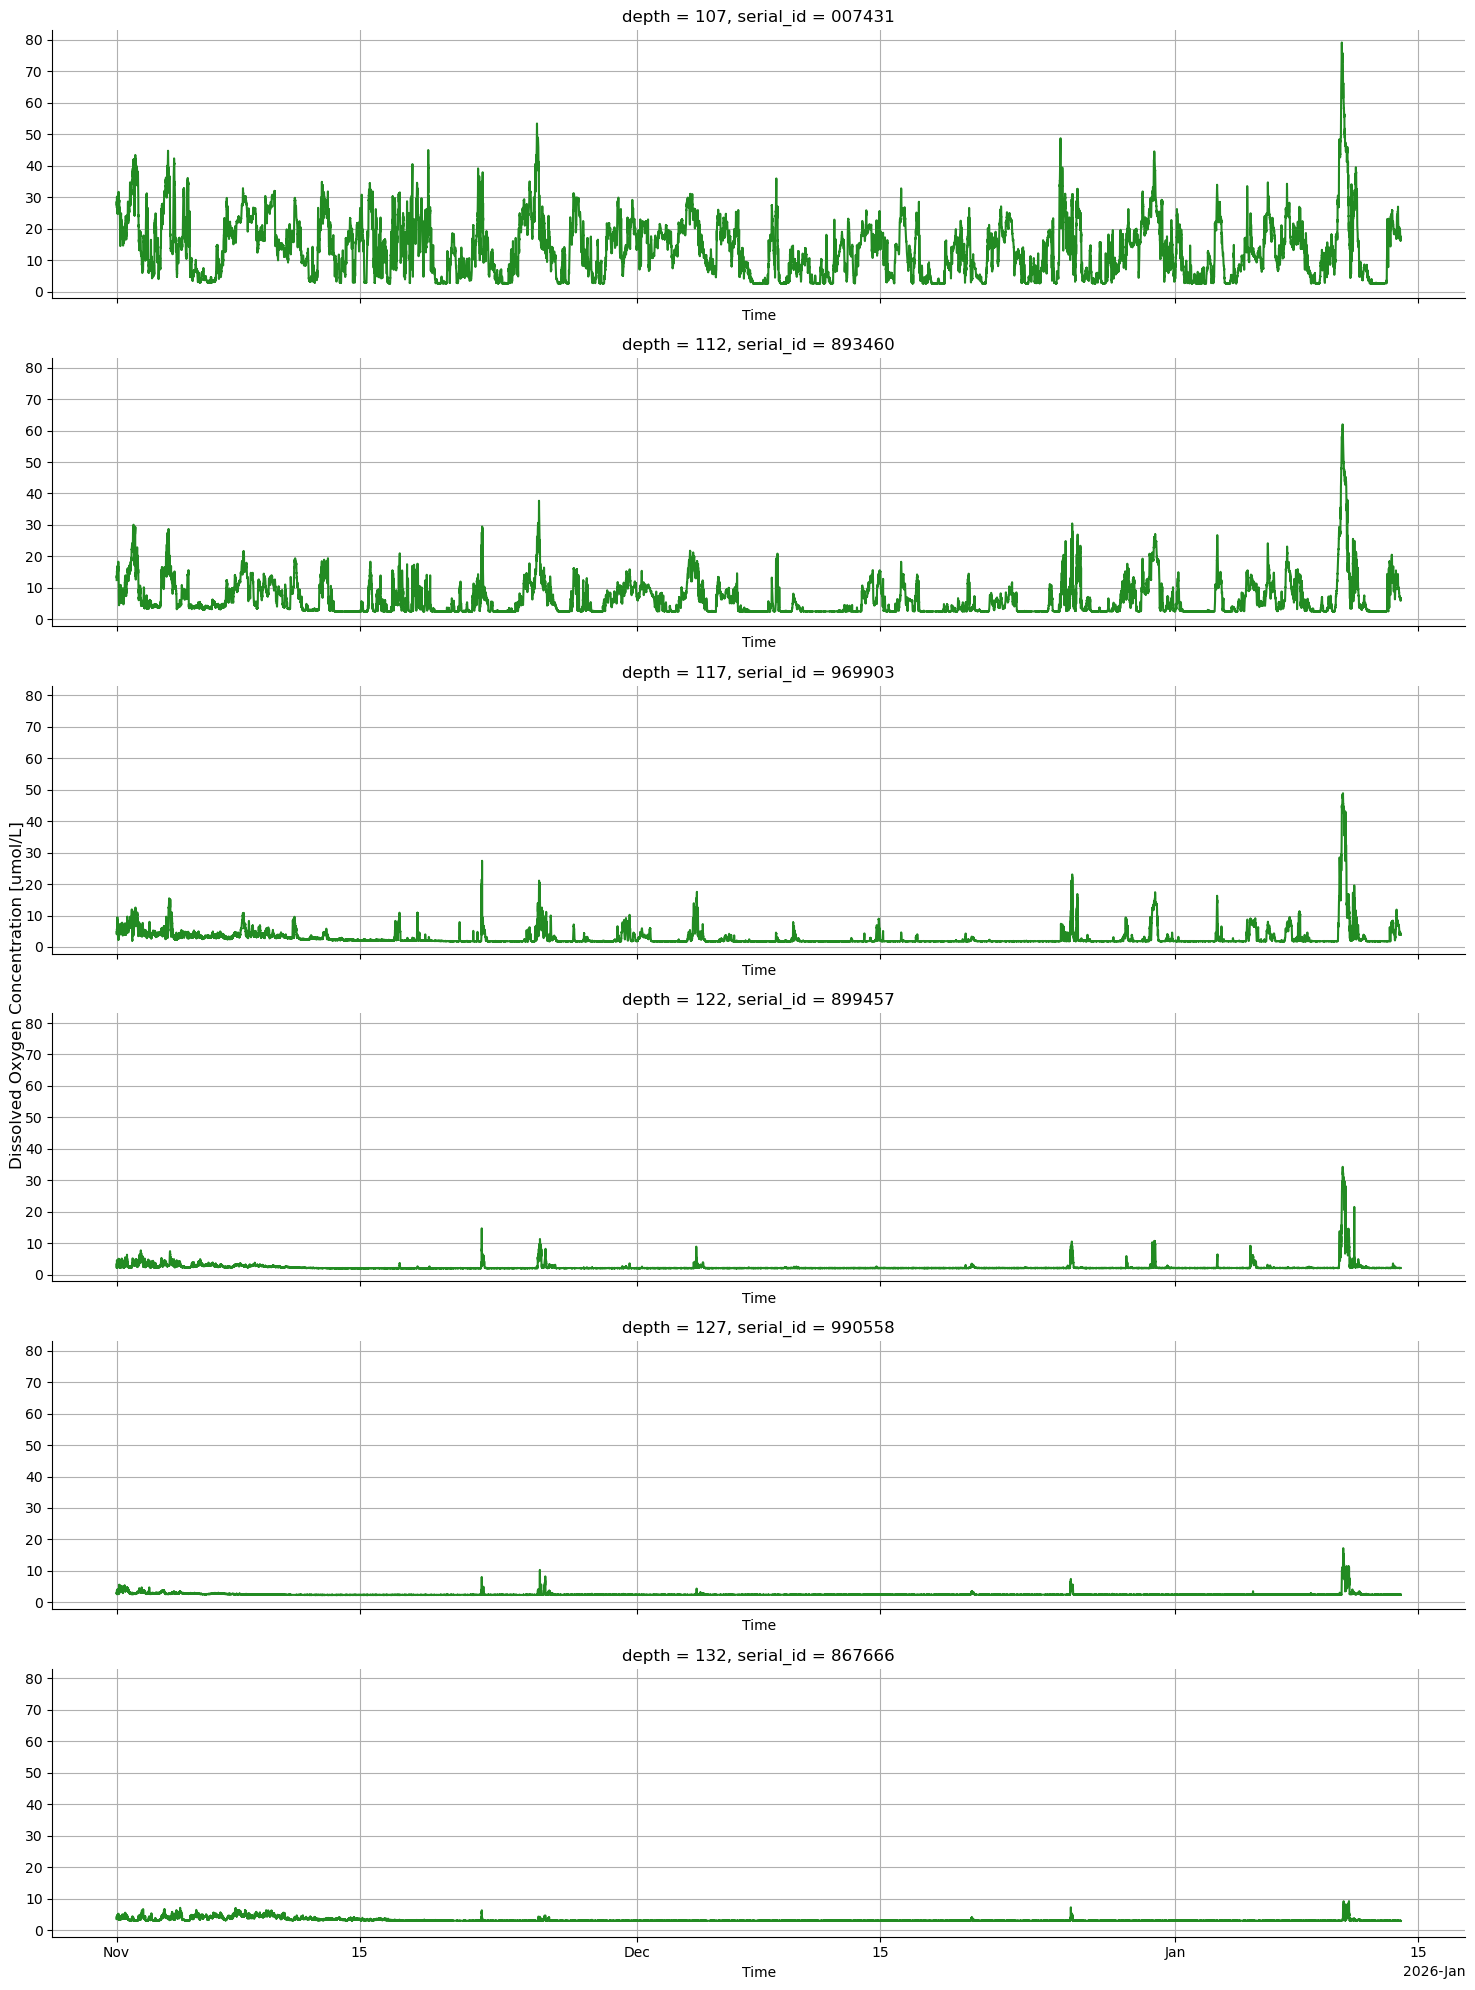

In [10]:
fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(15, 20), sharex=True, sharey=True)

for i, d in enumerate(ds_chain):
    d['d_oxygen_conc'].plot(color='forestgreen', ax=ax[i])
    #ax[i].axhline(0, color='black', ls='--')

    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('')

    ax[i].grid(True)
    ax[i].spines[['right', 'top']].set_visible(False)

fig.supylabel('Dissolved Oxygen Concentration [umol/L]')
plt.tight_layout()
plt.show()

### Thermistors

In [11]:
thermistors

[{'instrument': 'rbr_temp', 'serial_id': '200570', 'mab': 120, 'comments': ''},
 {'instrument': 'rbr_temp', 'serial_id': '200569', 'mab': 115, 'comments': ''},
 {'instrument': 'rbr_temp', 'serial_id': '205523', 'mab': 110, 'comments': ''},
 {'instrument': 'rbr_temp', 'serial_id': '205517', 'mab': 105, 'comments': ''},
 {'instrument': 'rbr_temp', 'serial_id': '205518', 'mab': 100, 'comments': ''},
 {'instrument': 'rbr_temp', 'serial_id': '205535', 'mab': 95, 'comments': ''},
 {'instrument': 'rbr_temp', 'serial_id': '205527', 'mab': 90, 'comments': ''},
 {'instrument': 'rbr_temp', 'serial_id': '209296', 'mab': 85, 'comments': ''},
 {'instrument': 'rbr_temp', 'serial_id': '205521', 'mab': 80, 'comments': ''},
 {'instrument': 'rbr_temp', 'serial_id': '200567', 'mab': 75, 'comments': ''},
 {'instrument': 'rbr_temp', 'serial_id': '205536', 'mab': 70, 'comments': ''},
 {'instrument': 'rbr_temp', 'serial_id': '200575', 'mab': 65, 'comments': ''},
 {'instrument': 'rbr_temp',
  'serial_id': '209

In [12]:
ds_chain = []
for t in thermistors:
    serial_id = t['serial_id']

    treader = ewg.thermistor_reader.ThermistorReader(serial_id, lake, location, year, date)
    ds = treader.load_from_L0()
    ds = ds.sel(time=slice(t_start, t_end))
    ds_chain.append(ds)

ds_temp = mreader.create_instrument_chain(ds_chain)

C:\Users\herremha\elcres\ewgreaders\ewgreaders\readers\mooring_reader.py:243: FutureWarning: In a future version of xarray the default value for coords will change from coords='different' to coords='minimal'. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set coords explicitly.
  return xr.concat(ds_aligned, dim='depth')


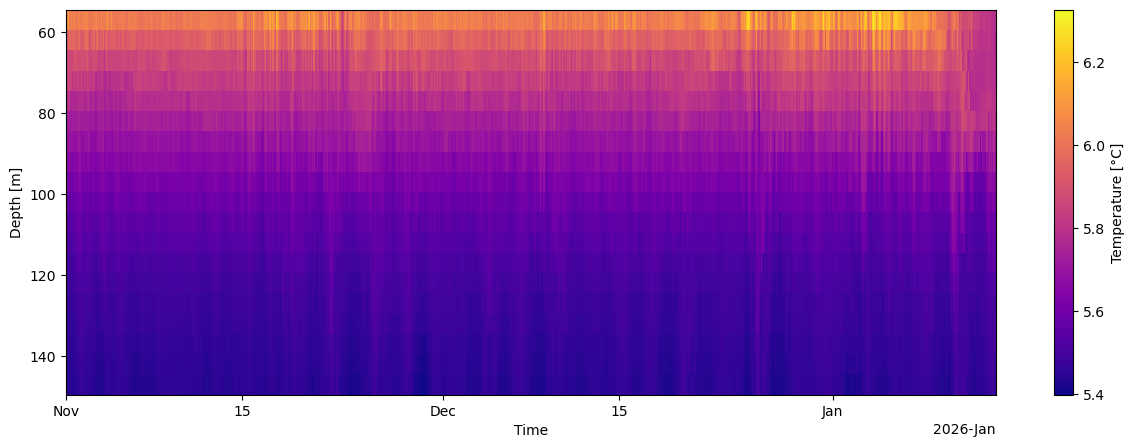

In [13]:
fig, ax = plt.subplots(figsize=(15, 5))
im = ds_temp.temp.plot(cmap='plasma', ax=ax)

ax.set_xlabel("Time")
ax.set_ylabel('Depth [m]')
im.colorbar.set_label("Temperature [°C]")

ax.invert_yaxis()
plt.show()

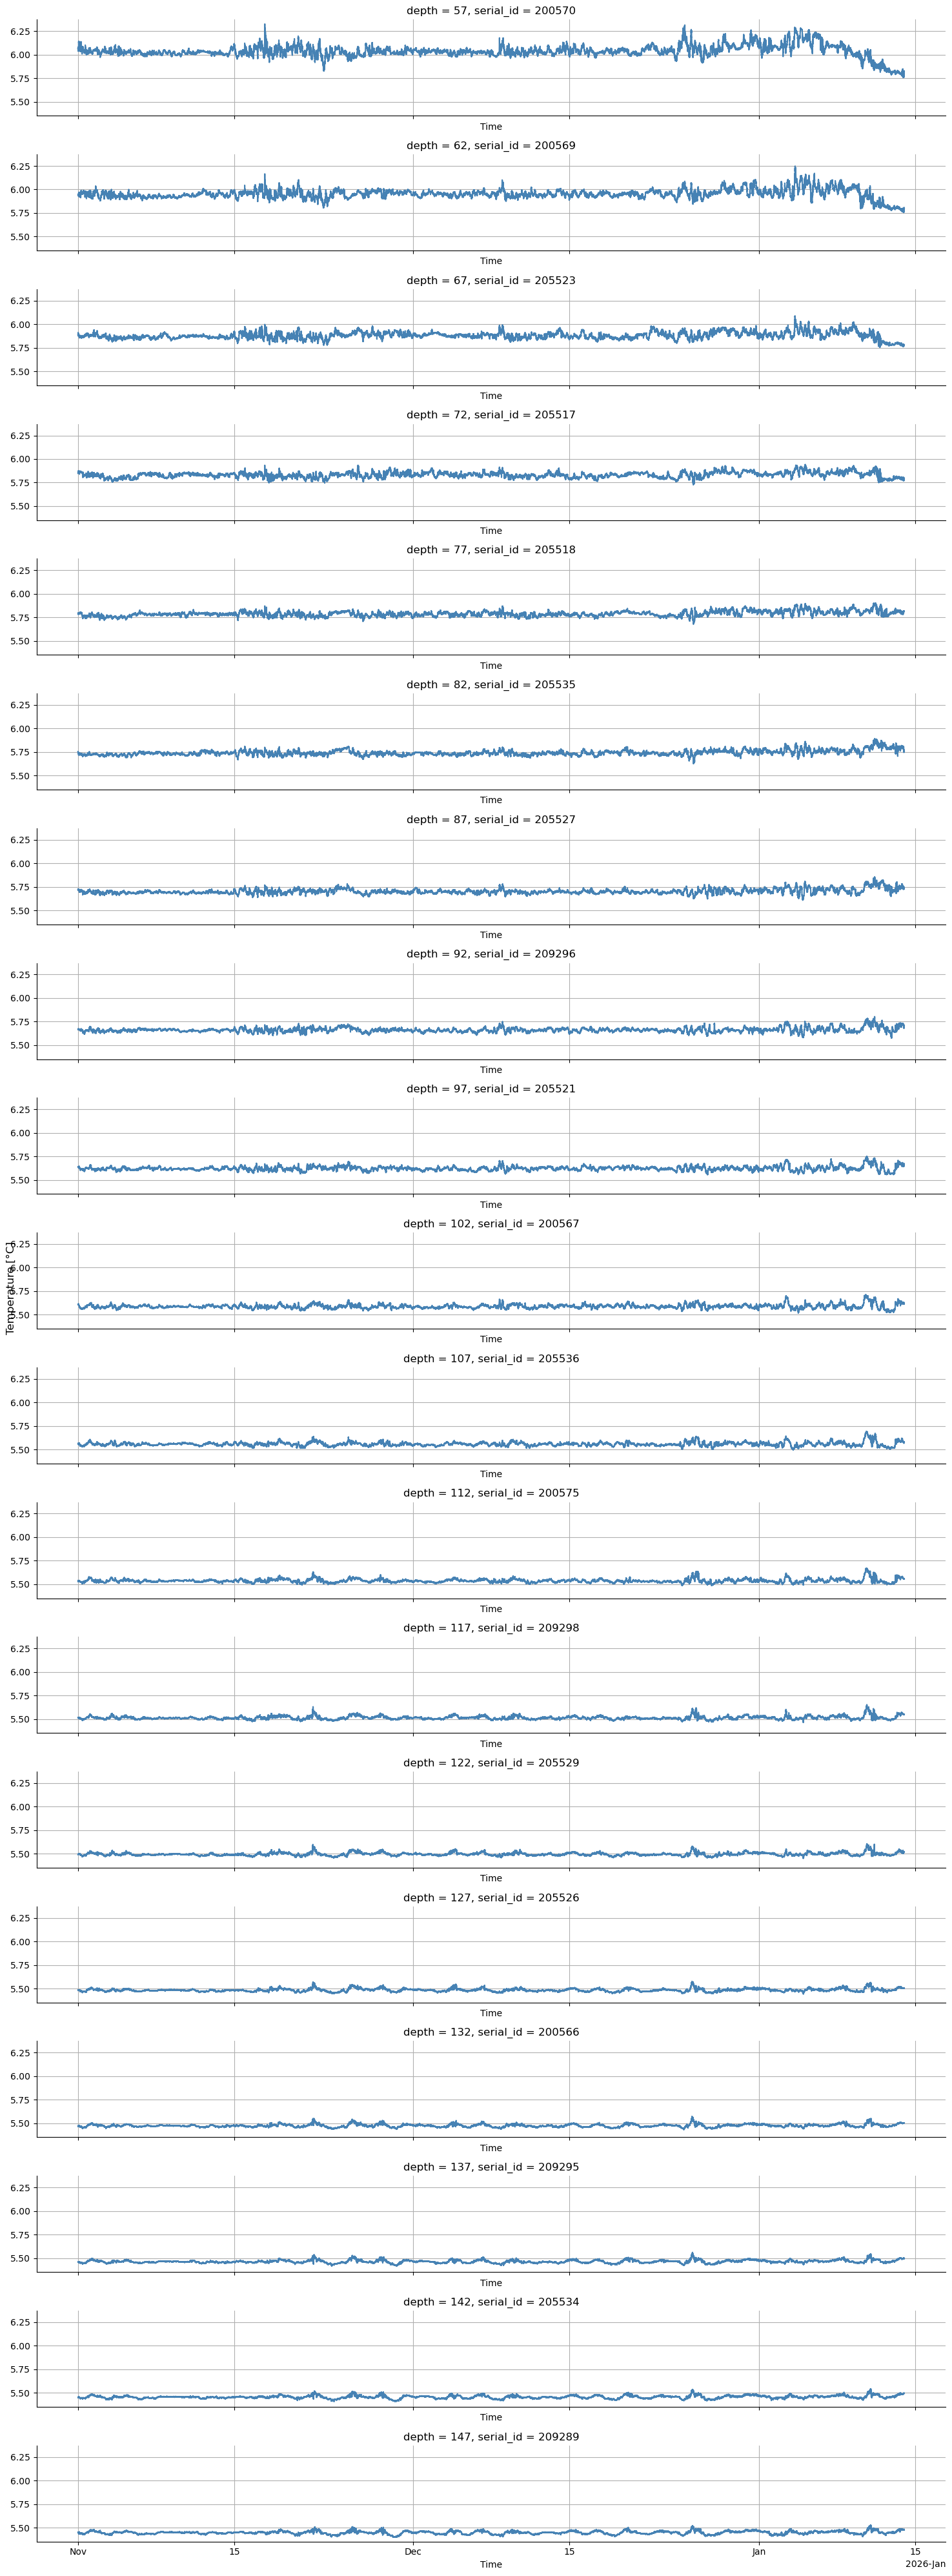

In [14]:
fig, ax = plt.subplots(nrows=len(thermistors), ncols=1, figsize=(15, 40), sharex=True, sharey=True)

for i, d in enumerate(ds_chain):
    d['temp'].plot(color='steelblue', ax=ax[i])
    #ax[i].axhline(0, color='black', ls='--')

    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('')

    ax[i].grid(True)
    ax[i].spines[['right', 'top']].set_visible(False)

fig.supylabel('Temperature [°C]')
plt.tight_layout()
plt.show()

### Flux and net transport

In [13]:
def plot_net_volume_transport(transport):
    fig, ax = plt.subplots(figsize=(5, 5))

    ax.axvline(0, color='black', linestyle='--')
    ax.plot(transport.values, transport.range, marker='o')

    ax.set_xlabel('Total Volume Transport [m^3]')
    ax.set_ylabel('Depth [m]')

    ax.invert_yaxis()
    ax.spines[['right', 'top']].set_visible(False)

    plt.show()

In [24]:
def plot_daily_volume_transport(df_avg):
    fig, ax = plt.subplots(figsize=(5, 5))

    ax.axvline(0, color='black', linestyle='--')
    sns.lineplot(df_avg, x='flux', y='range', orient='y', marker='o', errorbar=('se', 1), err_style='band', ax=ax)

    ax.set_xlabel('Daily Volume Transport [m^3]')
    ax.set_ylabel('Depth [m]')

    ax.invert_yaxis()
    ax.spines[['right', 'top']].set_visible(False)
    plt.show()

In [25]:
mxsc, mysc =  mreader.get_swiss_coords()
bathy = xr.open_dataset(mreader.BATHY_PATH.format(lake=lake))

In [26]:
ds = all_adcp[0]

flux_data = []
for d in ds.range.values:
    flux = ewg.lakes.volume_flux(ds, d, mxsc, mysc, 0, bathy)
    flux_data.append(flux)

ds_flux = xr.concat(flux_data, dim='range')

In [27]:
# require 50% data validity
thresh = 0.5
valid_depths = ds_flux.notnull().mean(dim='time')
ds_flux = ds_flux.sel(range=valid_depths >= thresh)

# calculate net transport
transport = ewg.lakes.net_volume_transport(ds_flux)

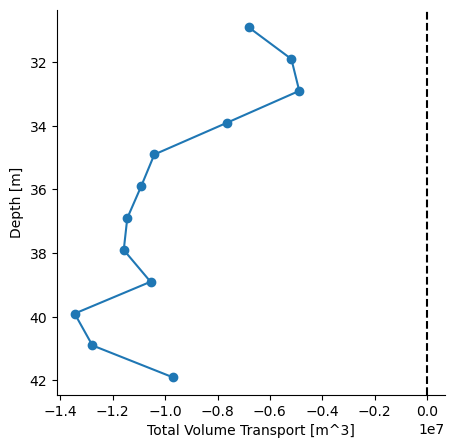

In [28]:
plot_net_volume_transport(transport)

In [29]:
dt = 600
# daily average
df = ds_flux.to_dataframe().reset_index()
df['flux'] = df['flux'] * dt
df['day'] = df['time'].dt.floor('D')
df_avg = df.groupby(['day', 'range'])['flux'].mean().reset_index()

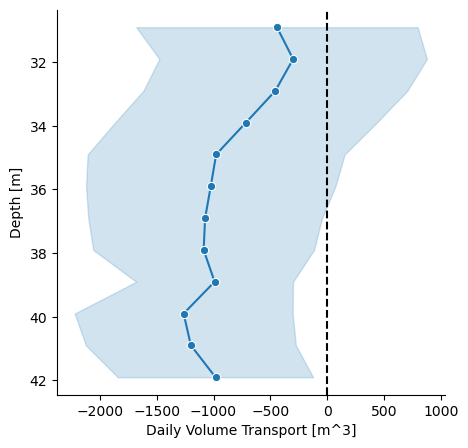

In [31]:
plot_daily_volume_transport(df_avg)

In [32]:
ds = all_adcp[1]

flux_data = []
for d in ds.range.values:
    flux = ewg.lakes.volume_flux(ds, d, mxsc, mysc, 0, bathy)
    flux_data.append(flux)

ds_flux = xr.concat(flux_data, dim='range')

In [33]:
# require 50% data validity
thresh = 0.5
valid_depths = ds_flux.notnull().mean(dim='time')
ds_flux = ds_flux.sel(range=valid_depths >= thresh)

# calculate net transport
transport = ewg.lakes.net_volume_transport(ds_flux)

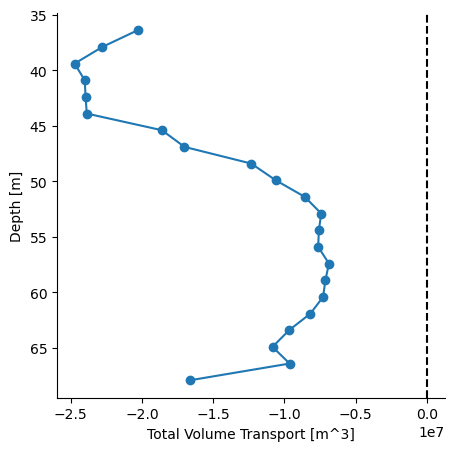

In [37]:
plot_net_volume_transport(transport)

In [38]:
dt = 600
# daily average
df = ds_flux.to_dataframe().reset_index()
df['flux'] = df['flux'] * dt
df['day'] = df['time'].dt.floor('D')
df_avg = df.groupby(['day', 'range'])['flux'].mean().reset_index()

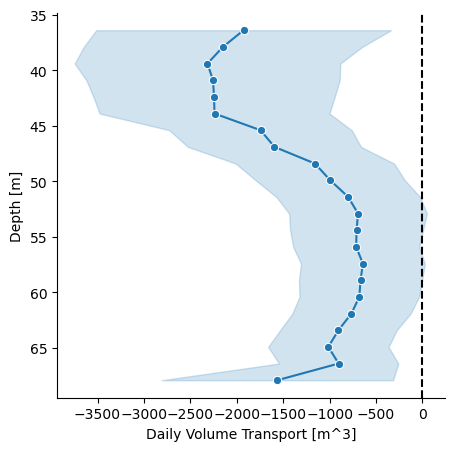

In [39]:
plot_daily_volume_transport(df_avg)

In [42]:
ds = all_adcp[2]

flux_data = []
for d in ds.range.values:
    flux = ewg.lakes.volume_flux(ds, d, mxsc, mysc, 0, bathy)
    flux_data.append(flux)

ds_flux = xr.concat(flux_data, dim='range')

In [43]:
# require 50% data validity
thresh = 0.5
valid_depths = ds_flux.notnull().mean(dim='time')
ds_flux = ds_flux.sel(range=valid_depths >= thresh)

# calculate net transport
transport = ewg.lakes.net_volume_transport(ds_flux)

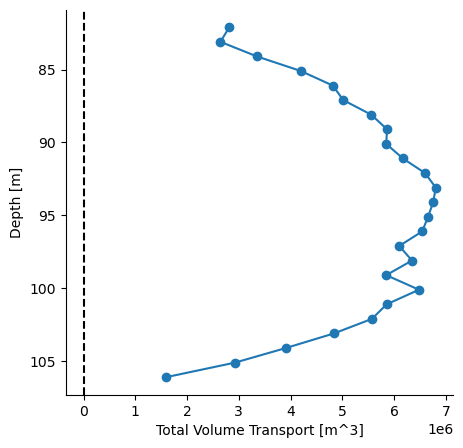

In [45]:
plot_net_volume_transport(transport)

In [46]:
dt = 600
# daily average
df = ds_flux.to_dataframe().reset_index()
df['flux'] = df['flux'] * dt
df['day'] = df['time'].dt.floor('D')
df_avg = df.groupby(['day', 'range'])['flux'].mean().reset_index()

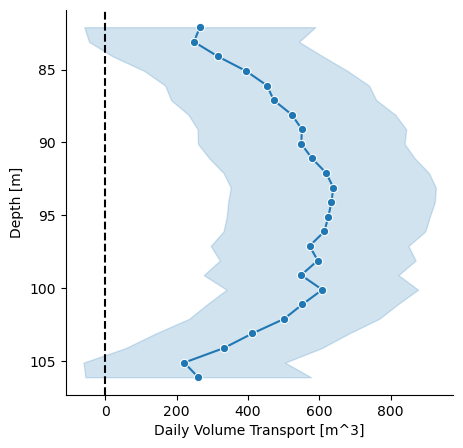

In [47]:
plot_daily_volume_transport(df_avg)

In [48]:
ds = all_adcp[3]

flux_data = []
for d in ds.range.values:
    if d < 126:
        flux = ewg.lakes.volume_flux(ds, d, mxsc, mysc, 0, bathy)
        flux_data.append(flux)

ds_flux = xr.concat(flux_data, dim='range')

In [49]:
# require 50% data validity
thresh = 0.5
valid_depths = ds_flux.notnull().mean(dim='time')
ds_flux = ds_flux.sel(range=valid_depths >= thresh)

# calculate net transport
transport = ewg.lakes.net_volume_transport(ds_flux)

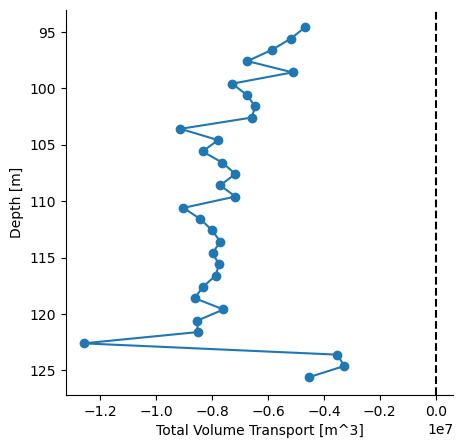

In [50]:
plot_net_volume_transport(transport)

In [51]:
dt = 600
# daily average
df = ds_flux.to_dataframe().reset_index()
df['flux'] = df['flux'] * dt
df['day'] = df['time'].dt.floor('D')
df_avg = df.groupby(['day', 'range'])['flux'].mean().reset_index()

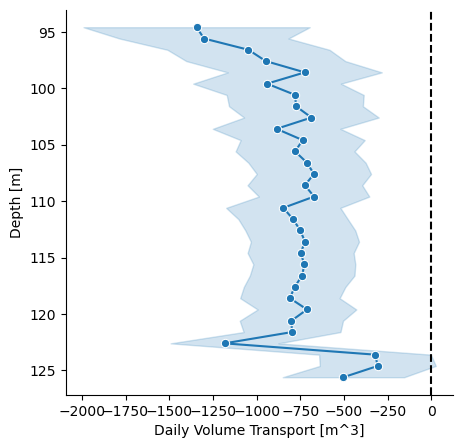

In [52]:
plot_daily_volume_transport(df_avg)

### Direction of maximal flow

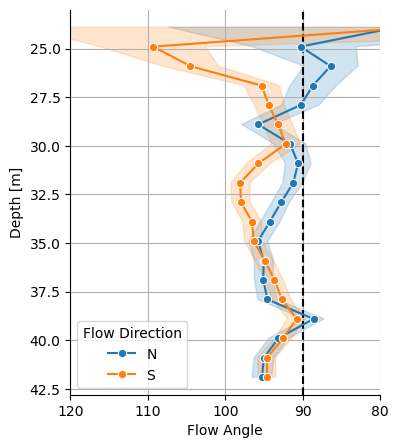

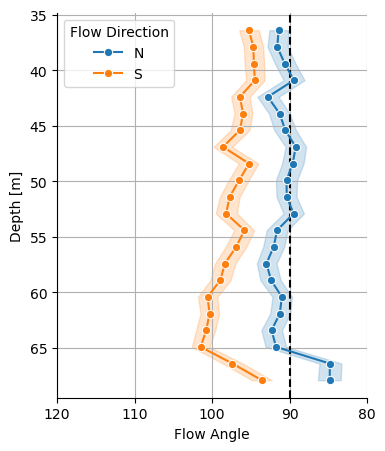

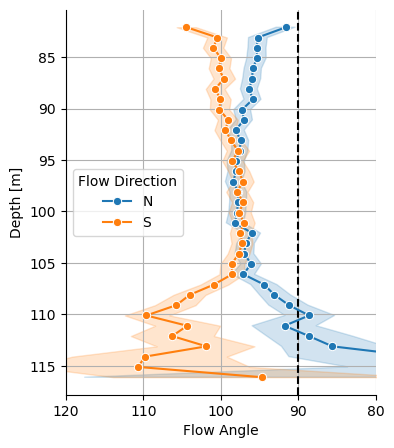

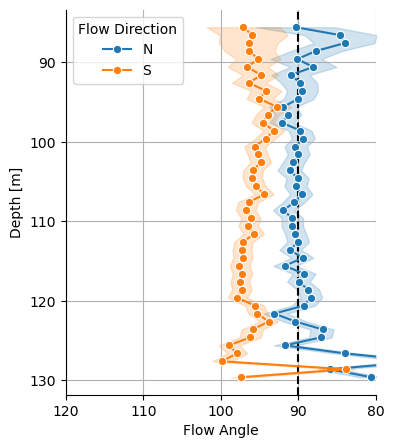

In [54]:
flow_ang_data = []
for ds in all_adcp:
    flow_ang = ewg.lakes.flow_angle(ds)
    flow_ang_data.append(flow_ang)

    df_angle = flow_ang.to_dataframe().reset_index().dropna()
    df_angle['angle_shifted'] = [a - 180 if a >= 180 else a for a in df_angle['angle']]
    df_angle['dir'] = ['N' if a < 180 else 'S' for a in df_angle['angle']]

    fig, ax = plt.subplots(figsize=(4, 5))

    ax.axvline(90, color='black', linestyle='--')
    sns.lineplot(df_angle, x='angle_shifted', y='range', orient='y', hue='dir', hue_order=['N', 'S'], marker='o', ax=ax)

    ax.set_xlabel('Flow Angle')
    ax.set_ylabel('Depth [m]')

    ax.set_xlim(80, 120)
    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.spines[['right', 'top']].set_visible(False)
    ax.grid(True)

    ax.legend(title='Flow Direction')

    plt.show()

### Excursion length

In [55]:
ds = all_adcp[0]

el_data = []
for d in ds.range.values:
    el = ewg.lakes.excursion_length(ds, d, 0)
    el_data.append(el)

df_el = pd.concat(el_data, ignore_index=True)

In [56]:
df_el_max = df_el.groupby(['depth', 'direction'])['excursion_length'].max().reset_index()

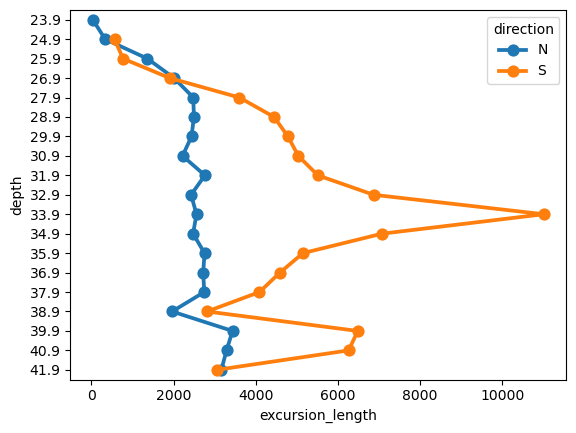

In [58]:
fig, ax = plt.subplots()
sns.pointplot(df_el_max, x='excursion_length', y='depth', hue='direction', orient='y', ax=ax)

plt.show()

In [59]:
ds = all_adcp[1]

el_data = []
for d in ds.range.values:
    el = ewg.lakes.excursion_length(ds, d, 0)
    el_data.append(el)

df_el = pd.concat(el_data, ignore_index=True)

In [60]:
df_el_max = df_el.groupby(['depth', 'direction'])['excursion_length'].max().reset_index()

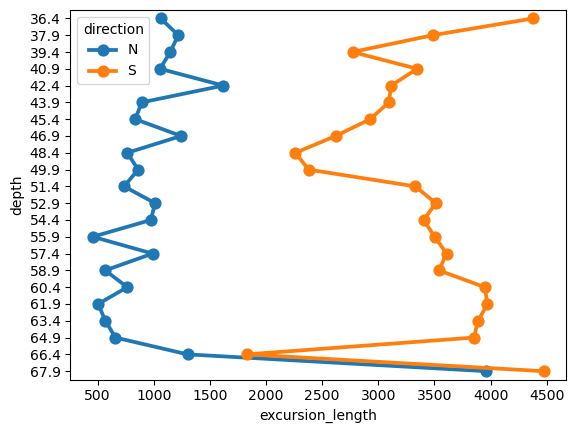

In [62]:
fig, ax = plt.subplots()
sns.pointplot(df_el_max, x='excursion_length', y='depth', hue='direction', orient='y', ax=ax)

plt.show()

In [63]:
ds = all_adcp[2]

el_data = []
for d in ds.range.values:
    el = ewg.lakes.excursion_length(ds, d, 0)
    el_data.append(el)

df_el = pd.concat(el_data, ignore_index=True)

In [64]:
df_el_max = df_el.groupby(['depth', 'direction'])['excursion_length'].max().reset_index()

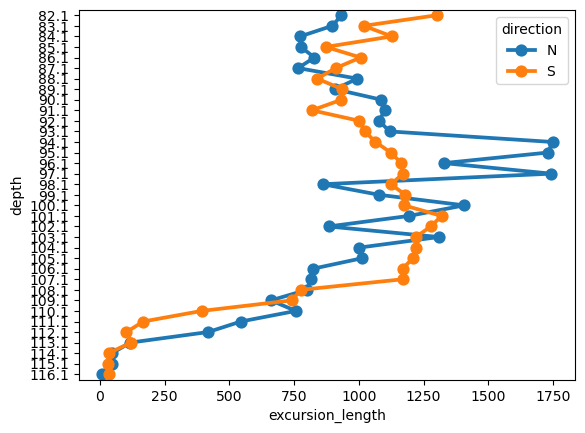

In [66]:
fig, ax = plt.subplots()
sns.pointplot(df_el_max, x='excursion_length', y='depth', hue='direction', orient='y', ax=ax)
plt.show()

In [67]:
ds = all_adcp[3]

el_data = []
for d in ds.range.values:
    el = ewg.lakes.excursion_length(ds, d, 0)
    el_data.append(el)

df_el = pd.concat(el_data, ignore_index=True)

In [68]:
df_el_max = df_el.groupby(['depth', 'direction'])['excursion_length'].max().reset_index()

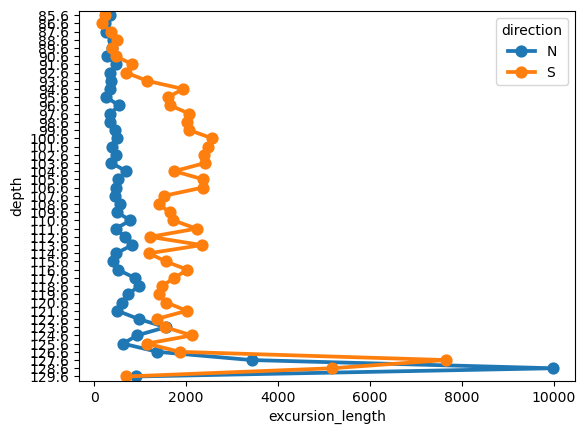

In [69]:
fig, ax = plt.subplots()
sns.pointplot(df_el_max, x='excursion_length', y='depth', hue='direction', orient='y', ax=ax)
plt.show()